[Info] Backend: FakeNairobiV2 (fallback)
[Info] Par físico conectado: (0, 1)

[Matriz de confusión A]
[[9.234e-01 6.050e-02 2.040e-02 1.200e-03]
 [5.660e-02 9.184e-01 1.500e-03 1.900e-02]
 [1.910e-02 1.000e-03 9.203e-01 6.000e-02]
 [9.000e-04 2.000e-02 5.790e-02 9.198e-01]]   cond(A)= 1.19e+00

=== Resultados (Deep Bell, ZNE) ===
Shots por escala: 8000, DEPTH_REPS=8, ReadoutMit=True
Distribuciones por escala (raw):
  s=1: {'01': 0.255, '00': 0.438375, '11': 0.19375, '10': 0.112875}
  s=3: {'00': 0.430125, '11': 0.182375, '01': 0.265875, '10': 0.121625}
  s=5: {'10': 0.1215, '01': 0.26475, '00': 0.437375, '11': 0.176375}
Distribuciones por escala (corrig. readout):
  s=1: {'00': 0.45622146330916924, '01': 0.24525028449473785, '10': 0.09995578533105892, '11': 0.19857246686503405}
  s=3: {'00': 0.4462376936264539, '01': 0.2579652927387221, '10': 0.11052327755000553, '11': 0.18527373608481856}
  s=5: {'00': 0.4541980296221868, '01': 0.25638455717609454, '10': 0.11064811002798829, '11': 0.1

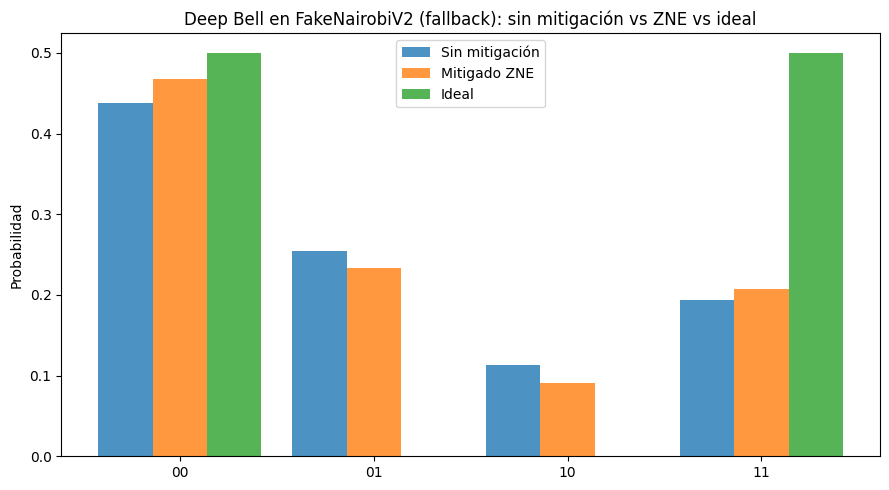

In [2]:
# =========================================================
# ZNE mejorado: (a) circuito más profundo + (b) ZNE sobre probs ya corregidas de readout
# Mantiene histograma: Sin mitigación / Mitigado ZNE / Ideal
# =========================================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# --------- Fake backend robusto ----------
FakeBackend = None
backend_label = None
try:
    from qiskit_ibm_runtime.fake_provider import FakeTorinoV2 as FB
    FakeBackend, backend_label = FB, "FakeTorinoV2"
except Exception:
    try:
        from qiskit.providers.fake_provider import FakeTorino as FB
        FakeBackend, backend_label = FB, "FakeTorino"
    except Exception:
        try:
            from qiskit_ibm_runtime.fake_provider import FakeNairobiV2 as FB
            FakeBackend, backend_label = FB, "FakeNairobiV2 (fallback)"
        except Exception:
            from qiskit_ibm_runtime.fake_provider import FakeManilaV2 as FB
            FakeBackend, backend_label = FB, "FakeManilaV2 (fallback)"

BASIS2 = ["00", "01", "10", "11"]

# --------- Flags para el experimento ----------
DEPTH_REPS = 8              # repeticiones de CX para acumular gate noise (prueba 12-20 si quieres más)
APPLY_READOUT_MITIGATION = True  # corregir readout antes de ZNE
SHOTS = 8000

# -------------------- Utilidades --------------------
def pick_connected_edge(backend):
    try:
        edges = backend.coupling_map.get_edges()  # V2
    except Exception:
        edges = backend.configuration().coupling_map  # V1
    if not edges:
        raise RuntimeError("El backend no tiene coupling map.")
    u, v = edges[0]
    return int(u), int(v)

def counts_to_probs(counts):
    shots = max(1, sum(counts.values()))
    return {k: v / shots for k, v in counts.items()}

def normalize_probs(probs, n_qubits=2):
    out = defaultdict(float); total = 0.0
    if isinstance(probs, dict):
        for k, v in probs.items():
            key = format(k, f"0{n_qubits}b") if isinstance(k, int) else str(k)
            out[key] += float(v); total += float(v)
    elif isinstance(probs, (list, np.ndarray)):
        for i, v in enumerate(probs):
            key = format(i, f"0{n_qubits}b")
            out[key] += float(v); total += float(v)
    else:
        raise TypeError("formato de probs no reconocido")
    if total > 0:
        for k in out: out[k] /= total
    for i in range(2**n_qubits):
        key = format(i, f"0{n_qubits}b"); out[key] += 0.0
    return dict(out)

def probs_vec_from_dict(pdict, basis=BASIS2):
    return np.array([pdict.get(s, 0.0) for s in basis], dtype=float)

def dict_from_probs_vec(vec, basis=BASIS2):
    vec = np.clip(vec, 0.0, 1.0)
    s = vec.sum()
    if s > 0: vec = vec / s
    return {basis[i]: float(vec[i]) for i in range(len(basis))}

def exp_ZZ_from_probs_dict(probs_dict):
    exp = 0.0
    for bitstr, p in probs_dict.items():
        z = 1
        for b in bitstr:
            z *= (1 if b == "0" else -1)
        exp += z * p
    return float(exp)

def total_variation_distance(p, q):
    keys = set(p) | set(q)
    return 0.5 * sum(abs(p.get(k,0) - q.get(k,0)) for k in keys)

def plot_bar_dists(p_raw, p_mitig, p_ideal, title="Distribuciones"):
    keys = BASIS2[:]; x = np.arange(len(keys)); w = 0.28
    plt.figure(figsize=(9,5))
    plt.bar(x - w, [p_raw.get(k,0) for k in keys], width=w, label="Sin mitigación", alpha=0.8)
    plt.bar(x,     [p_mitig.get(k,0) for k in keys], width=w, label="Mitigado ZNE", alpha=0.8)
    plt.bar(x + w, [p_ideal.get(k,0) for k in keys], width=w, label="Ideal", alpha=0.8)
    plt.xticks(x, keys); plt.ylabel("Probabilidad"); plt.title(title)
    plt.legend(); plt.tight_layout(); plt.show()

# ---------- Readout calibration (igual que en tu demo de A) ----------
def build_calibration_circuits():
    circs = []
    for state in BASIS2:
        qr = QuantumRegister(2, "q"); cr = ClassicalRegister(2, "c")
        qc = QuantumCircuit(qr, cr)
        if state[0] == "1": qc.x(qr[1])
        if state[1] == "1": qc.x(qr[0])
        qc.measure(qr, cr)
        circs.append(qc)
    return circs

def estimate_confusion_matrix(sim, layout, shots=20000):
    cal_circs = build_calibration_circuits()
    cal_transpiled = [transpile(c, backend=sim, initial_layout=layout, optimization_level=3) for c in cal_circs]
    res = sim.run(cal_transpiled, shots=shots).result()
    A = np.zeros((4, 4), dtype=float)
    for col, c in enumerate(cal_transpiled):
        counts = res.get_counts(c)
        p_meas = probs_vec_from_dict(normalize_probs(counts_to_probs(counts), 2), BASIS2)
        A[:, col] = p_meas
    return A

def apply_readout_mitigation(p_raw_dict, A):
    p_raw_vec = probs_vec_from_dict(p_raw_dict, BASIS2)
    A_pinv = np.linalg.pinv(A, rcond=1e-8)
    p_corr = A_pinv @ p_raw_vec
    p_corr = np.clip(p_corr, 0.0, 1.0)
    s = p_corr.sum()
    if s == 0: p_corr = np.ones(4)/4
    else:      p_corr = p_corr/s
    return dict_from_probs_vec(p_corr, BASIS2)

# -------------------- ZNE: folding + extrapolación --------------------
def deep_bell_ansatz(reps=8):
    """Bell con repetición de puertas para acumular ruido de puerta."""
    qc = QuantumCircuit(2, name="deep_bell")
    qc.h(0); qc.cx(0,1)
    for _ in range(reps-1):
        qc.rx(0.3, 0); qc.rz(0.2, 1)
        qc.cx(0,1)
    return qc

def global_fold(circ_no_meas, k: int):
    C = circ_no_meas
    Cinv = C.inverse()
    folded = QuantumCircuit(C.num_qubits, name=f"fold_{2*k+1}")
    folded.compose(C, inplace=True)
    for _ in range(k):
        folded.barrier(range(C.num_qubits))
        folded.compose(Cinv, inplace=True)
        folded.barrier(range(C.num_qubits))
        folded.compose(C, inplace=True)
    return folded

def with_measure(circ_unitary):
    qc = QuantumCircuit(circ_unitary.num_qubits, circ_unitary.num_qubits)
    qc.compose(circ_unitary, inplace=True)
    qc.measure(range(circ_unitary.num_qubits), range(circ_unitary.num_qubits))
    return qc

def run_counts(sim, qc, layout, shots=SHOTS, opt_level=0):
    qc_t = transpile(qc, backend=sim, initial_layout=layout, optimization_level=opt_level)
    res = sim.run(qc_t, shots=shots).result()
    return res.get_counts(qc_t)

def richardson_extrapolate(x_scales, y_vals):
    x = np.array(x_scales, dtype=float); y = np.array(y_vals, dtype=float)
    deg = 1 if len(x) == 2 else 2
    deg = min(deg, len(x)-1)
    coeff = np.polyfit(x, y, deg=deg)
    return float(np.polyval(coeff, 0.0))

# ------------------ Main demo ------------------
def main():
    backend = FakeBackend()
    print(f"[Info] Backend: {backend_label}")
    sim = AerSimulator.from_backend(backend)
    u, v = pick_connected_edge(backend)
    layout = [u, v]
    print(f"[Info] Par físico conectado: ({u}, {v})")

    # (0) Readout calibration (opcional)
    if APPLY_READOUT_MITIGATION:
        A = estimate_confusion_matrix(sim, layout, shots=20000)
        print("\n[Matriz de confusión A]")
        print(np.round(A, 4), "  cond(A)=", f"{np.linalg.cond(A):.2e}")
    else:
        A = None

    # (1) Circuito profundo base + escalas ZNE
    base_unitary = deep_bell_ansatz(DEPTH_REPS)
    scales = [1, 3, 5]

    # (2) Ejecutar por escala y obtener probs (y, si procede, corregir readout)
    probs_by_scale_raw = {}
    probs_by_scale_corr = {}

    for s in scales:
        k = (s - 1) // 2
        folded = global_fold(base_unitary, k)
        qc_meas = with_measure(folded)
        counts = run_counts(sim, qc_meas, layout=layout, shots=SHOTS, opt_level=0)
        p_raw = normalize_probs(counts_to_probs(counts), n_qubits=2)
        probs_by_scale_raw[s] = p_raw
        if A is not None:
            p_corr = apply_readout_mitigation(p_raw, A)
            probs_by_scale_corr[s] = p_corr

    # Usaremos como “baseline sin mitigación” la distribución s=1 sin corregir
    p_raw_baseline = probs_by_scale_raw[1]

    # (3) Extrapolación por bitstring (sobre probs corregidas si A!=None, si no, sobre raw)
    p_zne_vec = []
    for bitstr in BASIS2:
        ys = [ (probs_by_scale_corr if A is not None else probs_by_scale_raw)[s].get(bitstr,0.0)
               for s in scales ]
        y0 = richardson_extrapolate(scales, ys)
        p_zne_vec.append(y0)
    p_zne = dict_from_probs_vec(np.array(p_zne_vec), BASIS2)

    # (4) Métricas
    p_ideal = {"00":0.5, "01":0.0, "10":0.0, "11":0.5}
    zz_raw   = exp_ZZ_from_probs_dict(p_raw_baseline)
    zz_zne   = exp_ZZ_from_probs_dict(p_zne)
    tvd_raw  = total_variation_distance(p_raw_baseline, p_ideal)
    tvd_zne  = total_variation_distance(p_zne,          p_ideal)

    print("\n=== Resultados (Deep Bell, ZNE) ===")
    print(f"Shots por escala: {SHOTS}, DEPTH_REPS={DEPTH_REPS}, ReadoutMit={APPLY_READOUT_MITIGATION}")
    print("Distribuciones por escala (raw):")
    for s in scales: print(f"  s={s}: {probs_by_scale_raw[s]}")
    if A is not None:
        print("Distribuciones por escala (corrig. readout):")
        for s in scales: print(f"  s={s}: {probs_by_scale_corr[s]}")
    print(f"\nProbs  sin mitigación : {p_raw_baseline}")
    print(f"Probs  mitigadas ZNE  : {p_zne}")
    print(f"Ideal                 : {p_ideal}")

    print("\n— Expectación <ZZ> —")
    print(f"  Sin mitig. : {zz_raw:+.4f}")
    print(f"  Mitigado ZNE: {zz_zne:+.4f}")
    print(f"  Ideal      : {+1.0000:+.4f}")

    print("\n— TVD vs Ideal —")
    print(f"  Sin mitig. : {tvd_raw:.4f}")
    print(f"  Mitigado ZNE: {tvd_zne:.4f}")

    # (5) Histograma con mismo estilo
    plot_bar_dists(p_raw_baseline, p_zne, p_ideal,
                   title=f"Deep Bell en {backend_label}: sin mitigación vs ZNE vs ideal")

if __name__ == "__main__":
    main()
